

## Import Libraries
**Let's import all necessary libraries for the analysis and along with it let's bring down our dataset**


In [446]:
#!pip install wordcloud
#!pip install textblob
#!pip install cufflinks

<IPython.core.display.Javascript object>

In [447]:
# Basic libraries
import pandas as pd
import numpy as np


# NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing


# Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot

%matplotlib inline

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

<IPython.core.display.Javascript object>

## Importing the dataset
**Let's welcome our dataset and see what's inside the box**

In [448]:
raw_reviews = pd.read_csv(
    "C:\\Users\\fabio\\Downloads\\Musical_instruments_reviews.csv"
)
## print shape of dataset with rows and columns and information
print("The shape of the  data is (row, column):" + str(raw_reviews.shape))
print(raw_reviews.info())

The shape of the  data is (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


<IPython.core.display.Javascript object>

In [449]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

<IPython.core.display.Javascript object>

## Dataset Details
**This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time**

**Description of columns in the file:**

* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

<a id="section-two"></a>
# Preprocessing and cleaning

**We got to do lot of preprocessing before sending the reviews to the model. Let's go step by step.**

## Handling NaN values

**Let's check for null values**

In [450]:
# Creating a copy
process_reviews = raw_reviews.copy()

# Checking for null values
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

<IPython.core.display.Javascript object>

**We got null values in reviewer names and review text. Reviewer names doesn't add any value(we got id's instead) to our objective of the project. So let's focus on review text. I don't think dropping wouldn't be a problem as there are only 7 null values, but instead I'm thinking to impute that as missing and explore why they didn't leave any review . Could it be due to ratings?**

In [451]:
process_reviews["reviewText"] = process_reviews["reviewText"].fillna("Missing")

<IPython.core.display.Javascript object>

## Concatenating review text and summary
Let's combine review text and summary column. The sentiments won't be contradicting in nature. 

In [452]:
process_reviews["reviews"] = process_reviews["reviewText"] + process_reviews["summary"]
process_reviews = process_reviews.drop(["reviewText", "summary"], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

<IPython.core.display.Javascript object>

## Creating 'sentiment' column
**This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment**

In [453]:
def f(row):

    """This function returns sentiment value based on the overall ratings from the user"""

    if row["overall"] == 3.0:
        val = "Neutral"
    elif row["overall"] == 1.0 or row["overall"] == 2.0:
        val = "Negative"
    elif row["overall"] == 4.0 or row["overall"] == 5.0:
        val = "Positive"
    else:
        val = -1
    return val

<IPython.core.display.Javascript object>

In [454]:
# Applying the function in our new column
process_reviews["sentiment"] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

<IPython.core.display.Javascript object>

In [455]:
process_reviews["sentiment"].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

<IPython.core.display.Javascript object>

## Handling time column

**Here we have an unusual review time column which has date and year, once we split both we will split the date further into month and date.**

In [456]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n=1, expand=True)

# making separate date column from new data frame
process_reviews["date"] = new[0]

# making separate year column from new data frame
process_reviews["year"] = new[1]

process_reviews = process_reviews.drop(["reviewTime"], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   date   year  
0  Positive  02 28   2014  
1  Positive  03 16   2013  
2  Positive  08 28   2013  
3  Positive  02 14   2014  
4  Positive  02 21   2014

<IPython.core.display.Javascript object>

In [457]:
# Splitting the date
new1 = process_reviews["date"].str.split(" ", n=1, expand=True)

# adding month to the main dataset
process_reviews["month"] = new1[0]

# adding day to the main dataset
process_reviews["day"] = new1[1]

process_reviews = process_reviews.drop(["date"], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   year month day  
0  Positive   2014    02  28  
1  Positive   2013    03  16  
2  Positive   2013    08  28  
3  Positive   2014    02  14  
4  Positive   2014    02  21

<IPython.core.display.Javascript object>

## Finding the helpfulness of the review
**From the main dataframe we can see the helpful feature with values in list [a,b] format. It says that a out of b people found that review helpful. But with that format, it could not add value to the machine learning model and it will be difficult to decrypt the meaning for the machine. So we have planned to create helpful_rate feature which returns the ratio a/b value from [a,b].**

In [458]:
# Splitting the dataset based on comma and square bracket
new1 = process_reviews["helpful"].str.split(",", n=1, expand=True)
new2 = new1[0].str.split("[", n=1, expand=True)
new3 = new1[1].str.split("]", n=1, expand=True)

# Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

# Dropping empty columns due to splitting
new2 = new2.drop([0], axis=1)
new3 = new3.drop([1], axis=1)

# Concatenating the splitted columns
helpful = pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)


# Applying the function
helpful = trim_all_columns(helpful)

# Converting into integer types
helpful[0] = helpful[0].astype(str).astype(int)
helpful[1] = helpful[1].astype(str).astype(int)

# Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
    helpful["result"] = helpful[1] / helpful[0]
except ZeroDivisionError:
    helpful["result"] = 0

# Filling the NaN values(created due to dividing) with 0
helpful["result"] = helpful["result"].fillna(0)

# Rounding of the results to two decimal places
helpful["result"] = helpful["result"].round(2)

# Attaching the results to a new column of the main dataframe
process_reviews["helpful_rate"] = helpful["result"]

# dropping the helpful column from main dataframe
process_reviews = process_reviews.drop(["helpful"], axis=1)

<IPython.core.display.Javascript object>

In [459]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment   year month  \
0  Not much to write about here, but it does exac...  Positive   2014    02   
1  The product does exactly as it should and is q...  Positive   2013    03   
2  The primary job of this device is to block the...  Positive   2013    08   
3  Nice windscreen protects my MXL mic and preven...  Positive   2014    02   
4  This pop filter is great. It looks and perform...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

<IPython.core.display.Javascript object>

In [460]:
process_reviews["helpful_rate"].value_counts()

0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: helpful_rate, Length: 65, dtype: int64

<IPython.core.display.Javascript object>

**0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful**

## Review text-Punctuation Cleaning
**Let's begin our text processing by removing the punctuations**

In [461]:
# Removing unnecessary columns
process_reviews = process_reviews.drop(["reviewerName", "unixReviewTime"], axis=1)
# Creating a copy
clean_reviews = process_reviews.copy()

<IPython.core.display.Javascript object>

In [462]:
def review_cleaning(text):
    """Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    return text

<IPython.core.display.Javascript object>

In [463]:
process_reviews["reviews"] = process_reviews["reviews"].apply(
    lambda x: review_cleaning(x)
)
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much to write about here but it does exact...  Positive   2014    02   
1  the product does exactly as it should and is q...  Positive   2013    03   
2  the primary job of this device is to block the...  Positive   2013    08   
3  nice windscreen protects my mxl mic and preven...  Positive   2014    02   
4  this pop filter is great it looks and performs...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

<IPython.core.display.Javascript object>

**We have removed all punctuation in our review column**

## Review text-Stop words
**Coming to stop words, general nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So we have curated the stop words which doesn't have any negative sentiment or any negative alternatives.**

In [464]:
stop_words = [
    "yourselves",
    "between",
    "whom",
    "itself",
    "is",
    "she's",
    "up",
    "herself",
    "here",
    "your",
    "each",
    "we",
    "he",
    "my",
    "you've",
    "having",
    "in",
    "both",
    "for",
    "themselves",
    "are",
    "them",
    "other",
    "and",
    "an",
    "during",
    "their",
    "can",
    "yourself",
    "she",
    "until",
    "so",
    "these",
    "ours",
    "above",
    "what",
    "while",
    "have",
    "re",
    "more",
    "only",
    "needn't",
    "when",
    "just",
    "that",
    "were",
    "don't",
    "very",
    "should",
    "any",
    "y",
    "isn",
    "who",
    "a",
    "they",
    "to",
    "too",
    "should've",
    "has",
    "before",
    "into",
    "yours",
    "it's",
    "do",
    "against",
    "on",
    "now",
    "her",
    "ve",
    "d",
    "by",
    "am",
    "from",
    "about",
    "further",
    "that'll",
    "you'd",
    "you",
    "as",
    "how",
    "been",
    "the",
    "or",
    "doing",
    "such",
    "his",
    "himself",
    "ourselves",
    "was",
    "through",
    "out",
    "below",
    "own",
    "myself",
    "theirs",
    "me",
    "why",
    "once",
    "him",
    "than",
    "be",
    "most",
    "you'll",
    "same",
    "some",
    "with",
    "few",
    "it",
    "at",
    "after",
    "its",
    "which",
    "there",
    "our",
    "this",
    "hers",
    "being",
    "did",
    "of",
    "had",
    "under",
    "over",
    "again",
    "where",
    "those",
    "then",
    "you're",
    "i",
    "because",
    "does",
    "all",
]

<IPython.core.display.Javascript object>

In [465]:
process_reviews["reviews"] = process_reviews["reviews"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

<IPython.core.display.Javascript object>

We have removed all the stop words in the review column

<a id="section-three"></a>
# Exploratory data analysis

## Sentiments vs Helpful rate


In [466]:
pd.DataFrame(process_reviews.groupby("sentiment")["helpful_rate"].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.260505

<IPython.core.display.Javascript object>

**From the table we can see that the mean of helpful rate is higher for any negative reviews than neutral and positive reviews. These mean value might have been influenced by the 0 values in helpful rates. Lets check how it is distributed through violin plot**

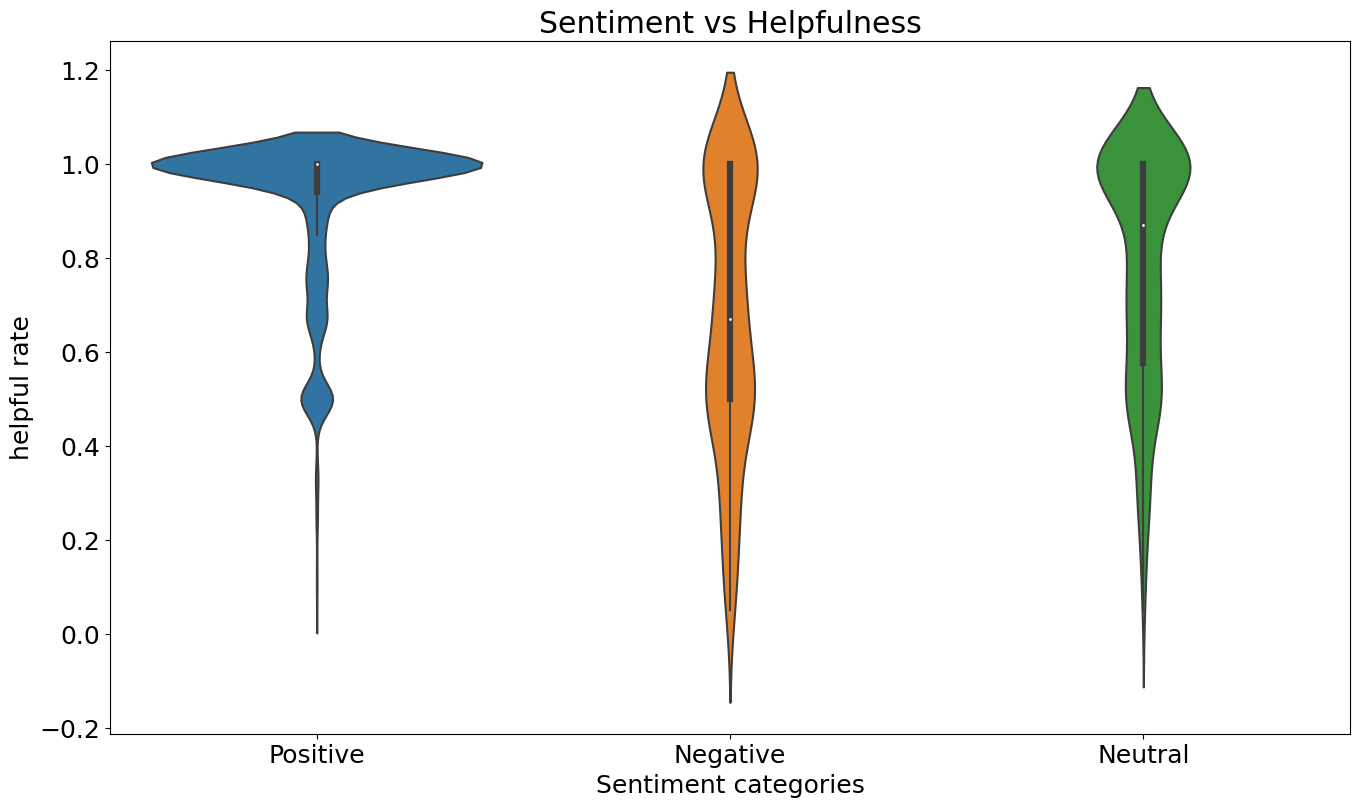

<IPython.core.display.Javascript object>

In [467]:
# plot layout
plt.rcParams.update({"font.size": 18})
rcParams["figure.figsize"] = 16, 9

# Creating dataframe and removing 0 helpfulrate records
senti_help = pd.DataFrame(process_reviews, columns=["sentiment", "helpful_rate"])
senti_help = senti_help[senti_help["helpful_rate"] != 0.00]

# Plotting phase
sns.violinplot(x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title("Sentiment vs Helpfulness")
plt.xlabel("Sentiment categories")
plt.ylabel("helpful rate")
plt.show()

**Insights:** <br>

**From the plot we can declare that more number of positive reviews are having high helpful rate. We got deceived by the mean value, it's better to look at a plot rather than taking some measures of central tendency under such situation. **

## Year vs Sentiment count
**In this block we will see how many reviews were posted based on sentiments in each year from 2004 to 2014**

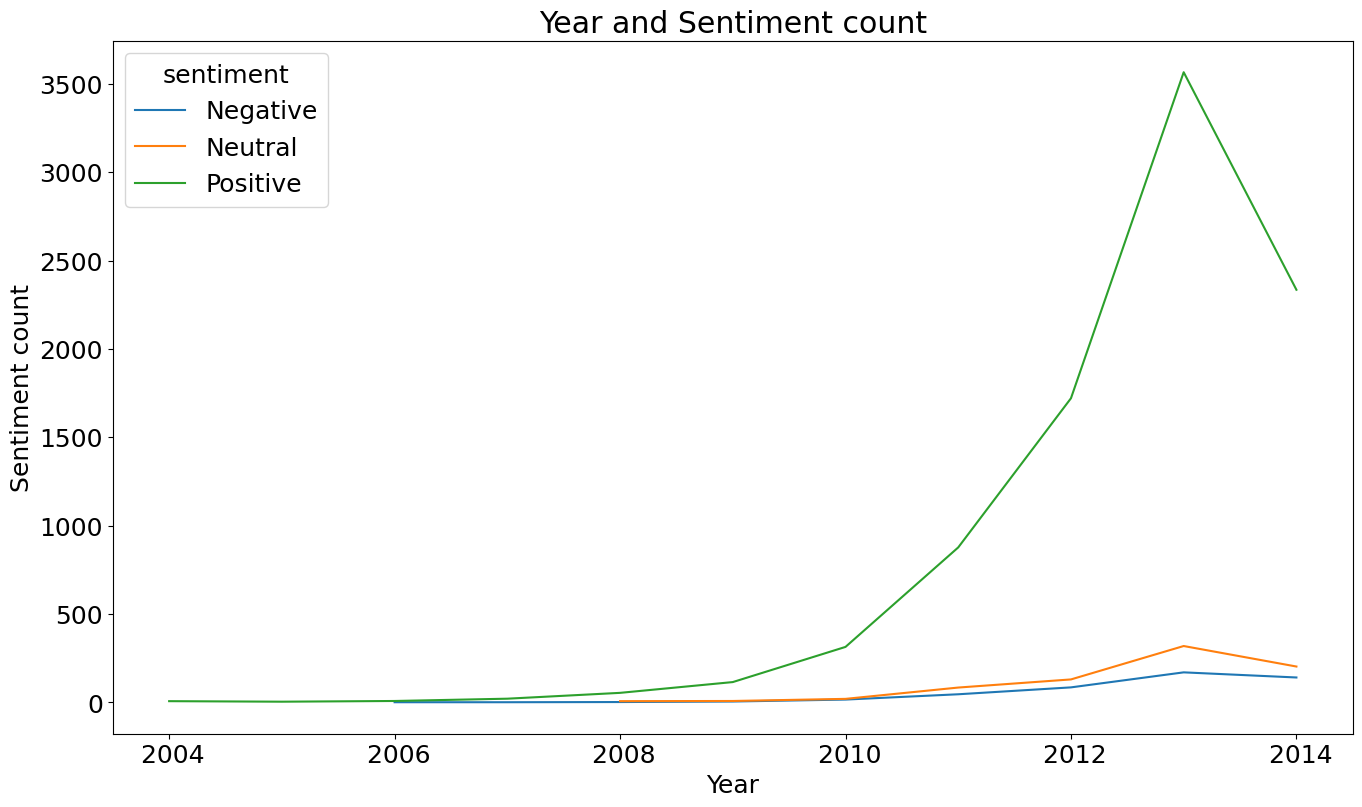

<IPython.core.display.Javascript object>

In [468]:
process_reviews.groupby(["year", "sentiment"])["sentiment"].count().unstack().plot(
    legend=True
)
plt.title("Year and Sentiment count")
plt.xlabel("Year")
plt.ylabel("Sentiment count")
plt.show()

**Insights:** <br>
**From the plot we can clearly see the rise in positive reviews from 2010. Reaching its peak around 2013 and there is a dip in 2014, All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. **

## Day of month vs Reviews count
**Let's check if there are any relationship between reviews and day of month**

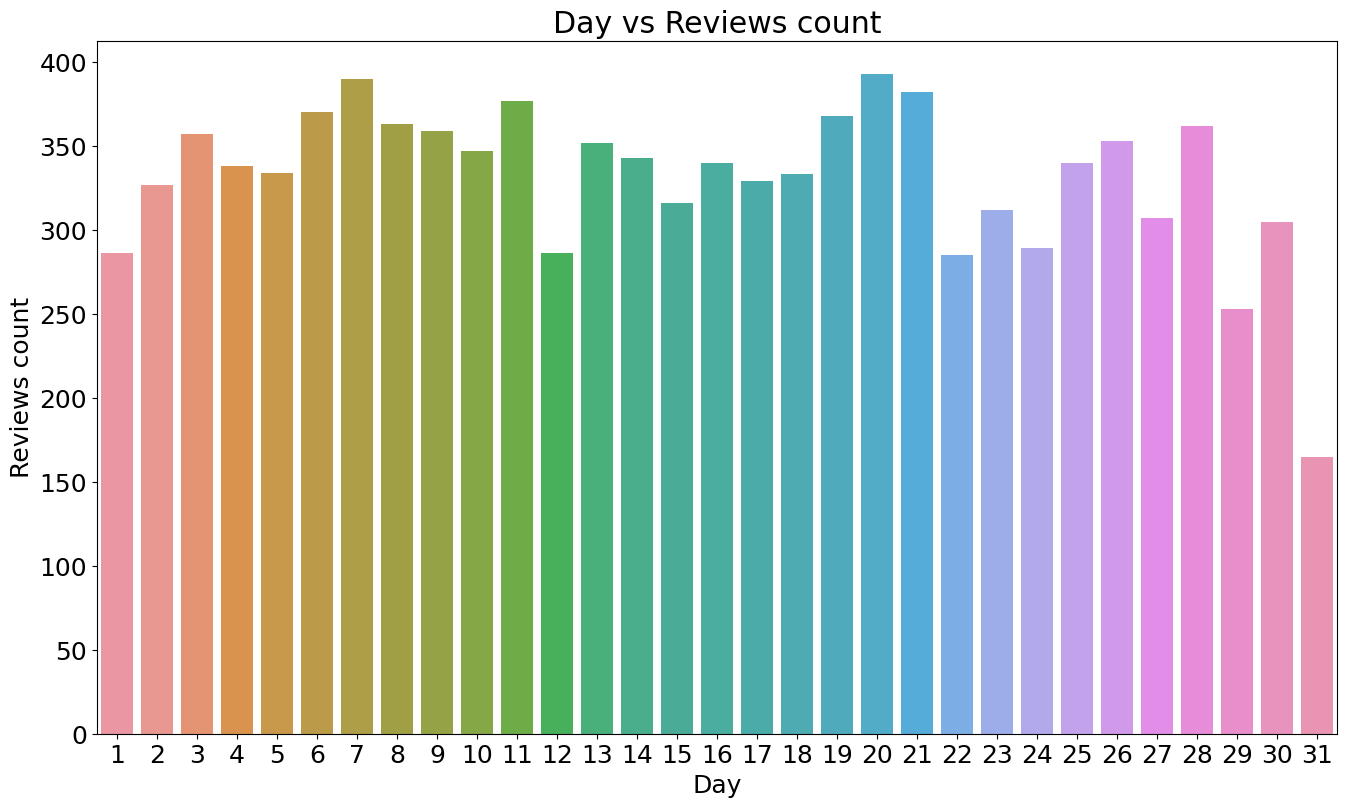

<IPython.core.display.Javascript object>

In [469]:
# Creating a dataframe
day = pd.DataFrame(process_reviews.groupby("day")["reviews"].count()).reset_index()
day["day"] = day["day"].astype("int64")
day.sort_values(by=["day"])

# Plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title("Day vs Reviews count")
plt.xlabel("Day")
plt.ylabel("Reviews count")
plt.show()

**Insights:** <br>
**The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month. This drop could be due to the fact that not every month has 31 days!**

## Creating few more features for text analysis
**Now, let's create polarity, review length and word count**

**Polarity:** **We use Textblob for for figuring out the rate of sentiment . It is between [-1,1] where -1 is negative and 1 is positive polarity**

**Review length:** **length of the review which includes each letters and spaces**

**Word length:** **This measures how many words are there in review**

In [470]:
process_reviews["polarity"] = process_reviews["reviews"].map(
    lambda text: TextBlob(text).sentiment.polarity
)
process_reviews["review_len"] = process_reviews["reviews"].astype(str).apply(len)
process_reviews["word_count"] = process_reviews["reviews"].apply(
    lambda x: len(str(x).split())
)

<IPython.core.display.Javascript object>

In [471]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  polarity  review_len  word_count  
0  28          0.00  0.250000         162          25  
1  16          0.93  0.014286         356          55  
2  28          1.00  0.167500         315          48  
3  14          0.00  0.333333         169          22  
4  21          0.00  0.800000         136          21

<IPython.core.display.Javascript object>

In [472]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

<IPython.core.display.Javascript object>

## Sentiment polarity distribution
**Let's look at our polarity distribution**

In [473]:
process_reviews["polarity"].iplot(
    kind="hist",
    bins=50,
    xTitle="polarity",
    linecolor="black",
    yTitle="count",
    title="Sentiment Polarity Distribution",
)

<IPython.core.display.Javascript object>

**Insights:**
* **We have a lot of positive polarities compared to the negative polarities**
* **This polarity distributions assures the number of positive reviews we had**
* **We can say that this polarity is a normally distributed but not standard normal**


## Review Rating Distribution
**Let's check out how overall ratings are distributed**

In [474]:
process_reviews["overall"].iplot(
    kind="hist",
    xTitle="rating",
    linecolor="black",
    yTitle="count",
    title="Review Rating Distribution",
)

<IPython.core.display.Javascript object>

**We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature **

## Review Text Length Distribution
**Let's check out the length of review text**

In [475]:
process_reviews["review_len"].iplot(
    kind="hist",
    bins=100,
    xTitle="review length",
    linecolor="black",
    yTitle="count",
    title="Review Text Length Distribution",
)

<IPython.core.display.Javascript object>

**We have a right skewed distribution where most of the lengths falls between 0-1000**

## Review Text Word Count Distribution
**Let's check out the word count of review text**

In [476]:
process_reviews["word_count"].iplot(
    kind="hist",
    bins=100,
    xTitle="word count",
    linecolor="black",
    yTitle="count",
    title="Review Text Word Count Distribution",
)

<IPython.core.display.Javascript object>

**We have a right skewed distribution with most of the words falling between 0-200 in a a review** 

## N-gram analysis
**Welcome to the deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment **

## Monogram analysis
**Here we will plot most frequent **one word in reviews** based on sentiments**

In [477]:
# Filtering data
review_pos = process_reviews[process_reviews["sentiment"] == "Positive"].dropna()
review_neu = process_reviews[process_reviews["sentiment"] == "Neutral"].dropna()
review_neg = process_reviews[process_reviews["sentiment"] == "Negative"].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [
        token
        for token in text.lower().split(" ")
        if token != ""
        if token not in STOPWORDS
    ]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation="h",
        marker=dict(
            color=color,
        ),
    )
    return trace


## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), "green")

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), "grey")

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), "red")

# Creating two subplots
fig = tools.make_subplots(
    rows=3,
    cols=1,
    vertical_spacing=0.04,
    subplot_titles=[
        "Frequent words of positive reviews",
        "Frequent words of neutral reviews",
        "Frequent words of negative reviews",
    ],
)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig["layout"].update(
    height=1200, width=900, paper_bgcolor="rgb(233,233,233)", title="Word Count Plots"
)
iplot(fig, filename="word-plots")

<IPython.core.display.Javascript object>

**As we see, the words doen't match with the sentiment except few. Through monogram we can't judge a sendiment based on one word. So let's try with frequent two words**

## Bigram analysis
**Here we will plot most frequent two words in reviews based on sentiments**

In [478]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), "green")

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), "grey")

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), "brown")


# Creating two subplots
fig = tools.make_subplots(
    rows=3,
    cols=1,
    vertical_spacing=0.04,
    horizontal_spacing=0.25,
    subplot_titles=[
        "Bigram plots of Positive reviews",
        "Bigram plots of Neutral reviews",
        "Bigram plots of Negative reviews",
    ],
)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig["layout"].update(
    height=1000, width=800, paper_bgcolor="rgb(233,233,233)", title="Bigram Plots"
)
iplot(fig, filename="word-plots")

<IPython.core.display.Javascript object>

**Here we can get a clear idea about the sentiments from the bi-words**

## Trigram analysis
**Here we will plot most frequent three words in reviews based on sentiments**

In [479]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')


<IPython.core.display.Javascript object>

**We have completed our text ngram analysis. Let's look at wordcloud **

## Wordcloud-Positive reviews

**Let's look at the word cloud of positive reviews**

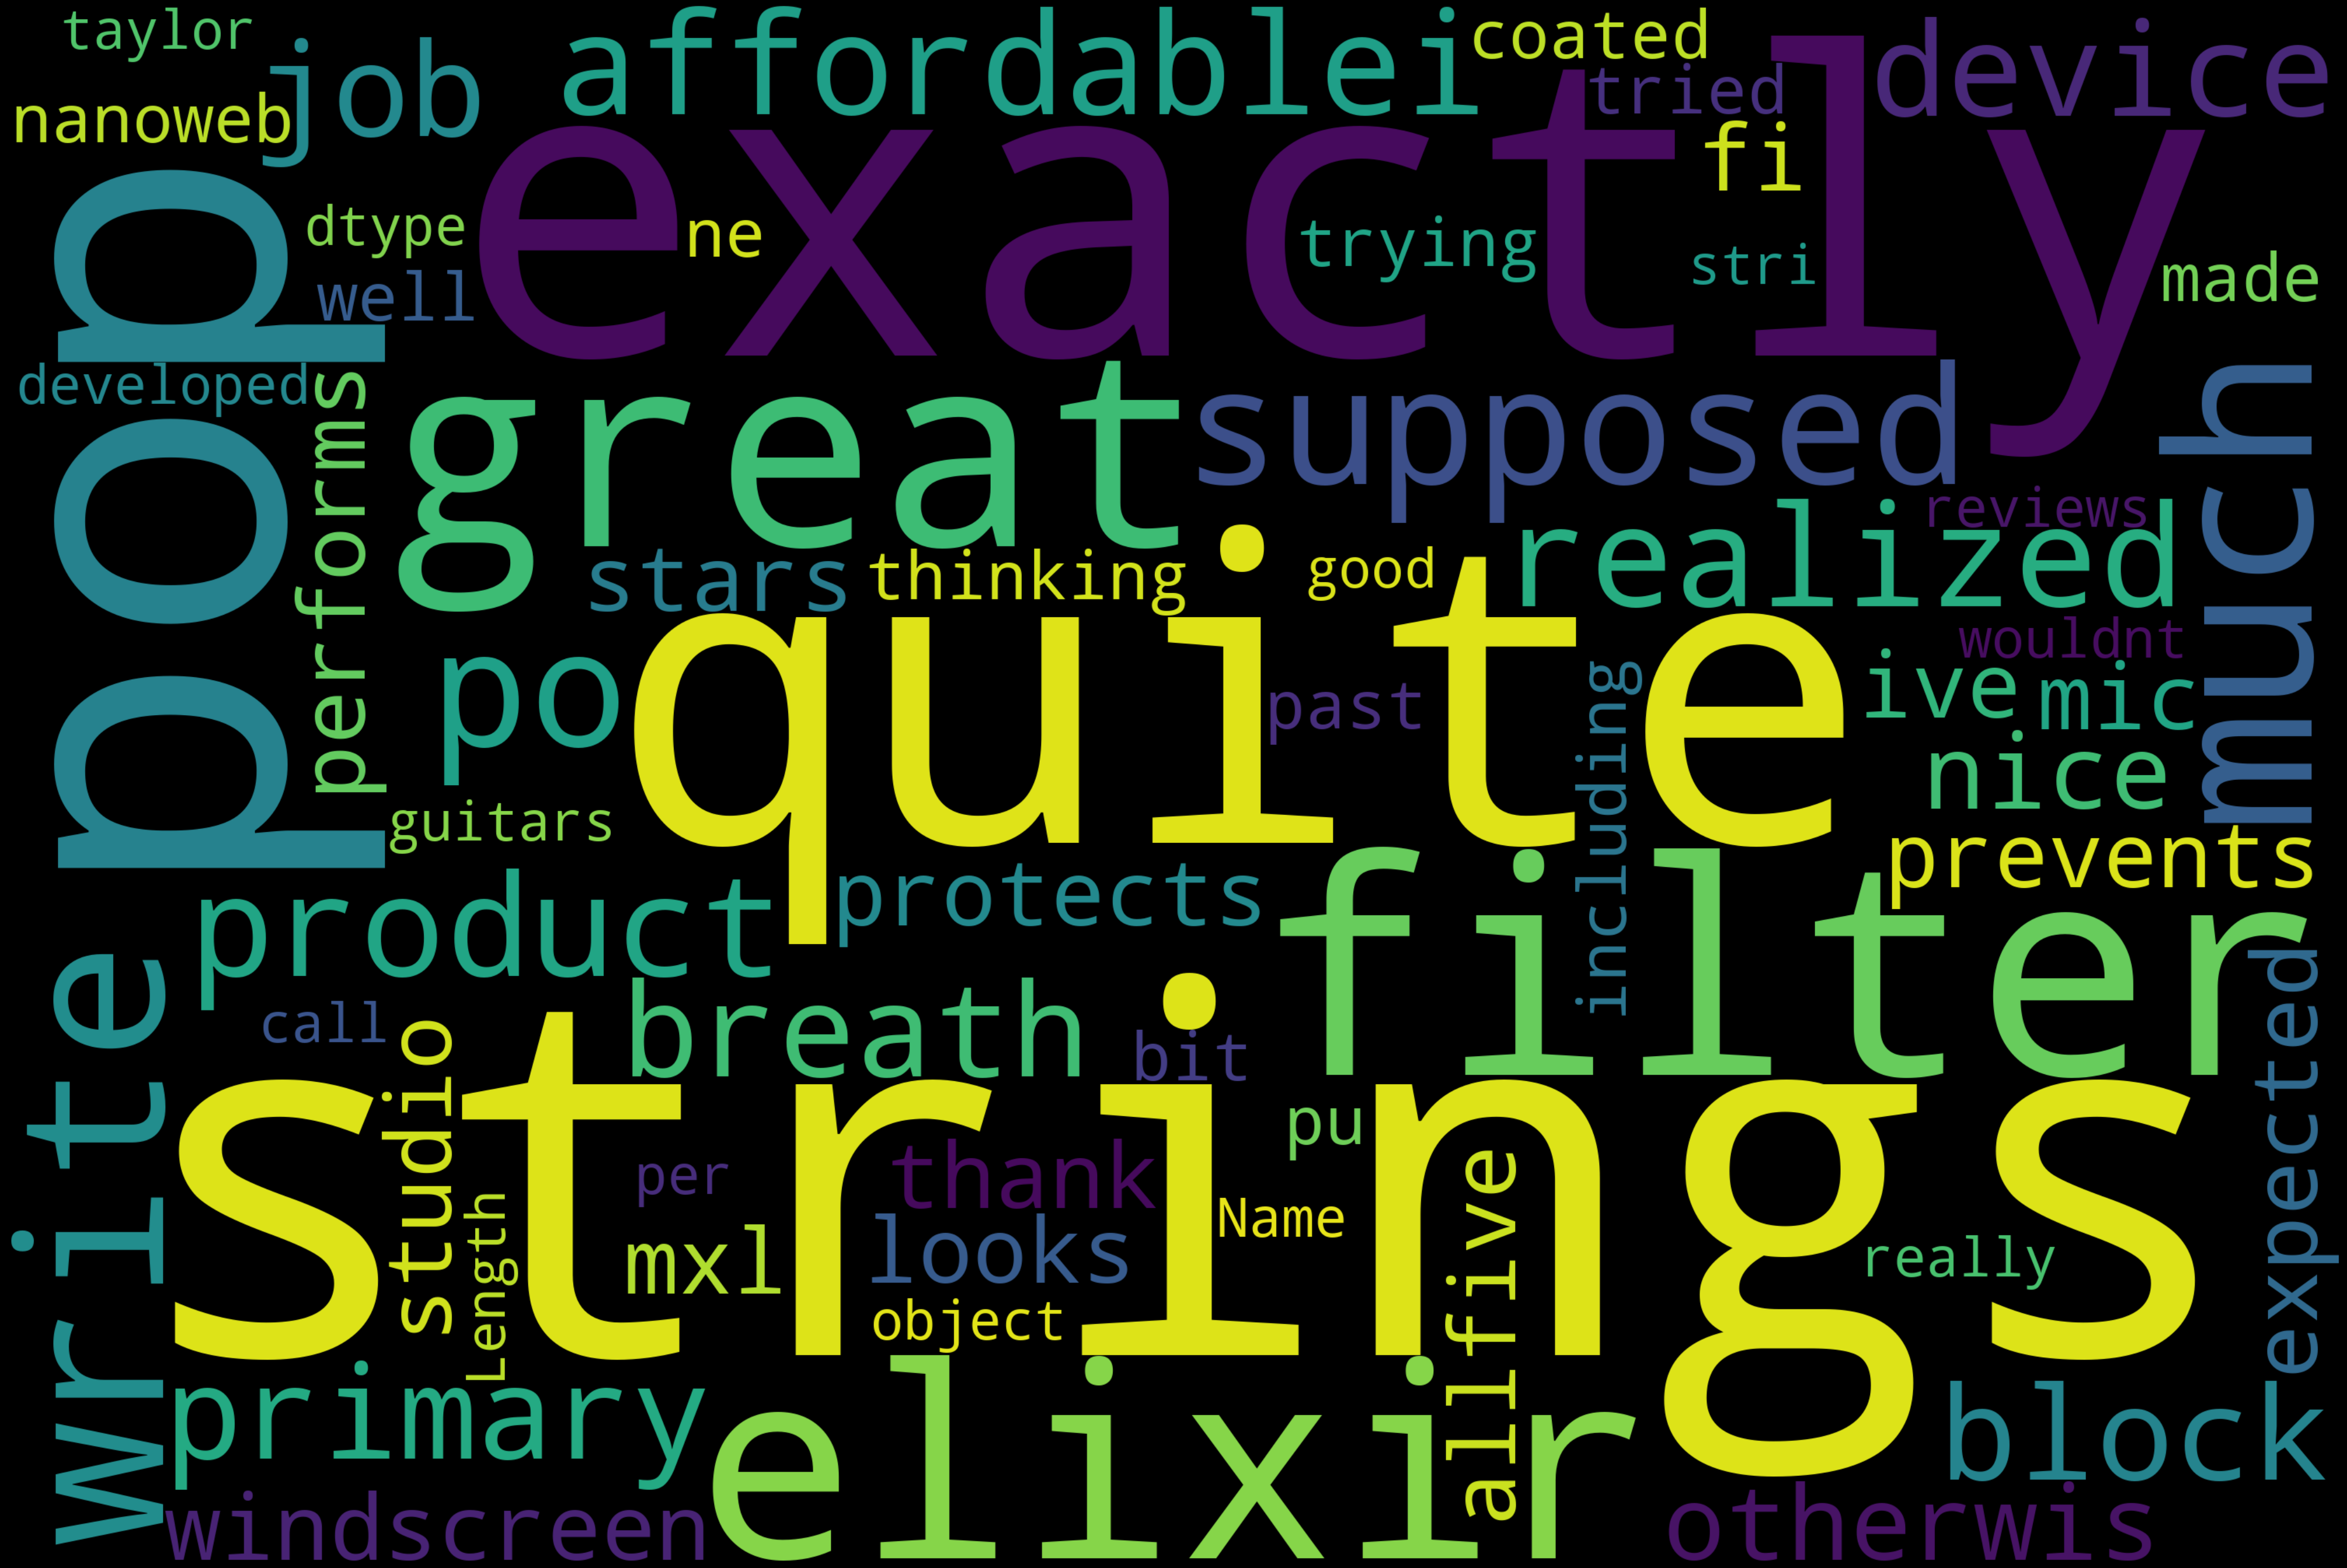

<IPython.core.display.Javascript object>

In [480]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width=3000, height=2000, background_color="black", stopwords=STOPWORDS
).generate(str(text))
fig = plt.figure(figsize=(40, 30), facecolor="k", edgecolor="k")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**We can see positive words like great,affordable,expected,exactly etc.,**

## Wordcloud-Neutral reviews

**Let's look at the word cloud of neutral reviews**

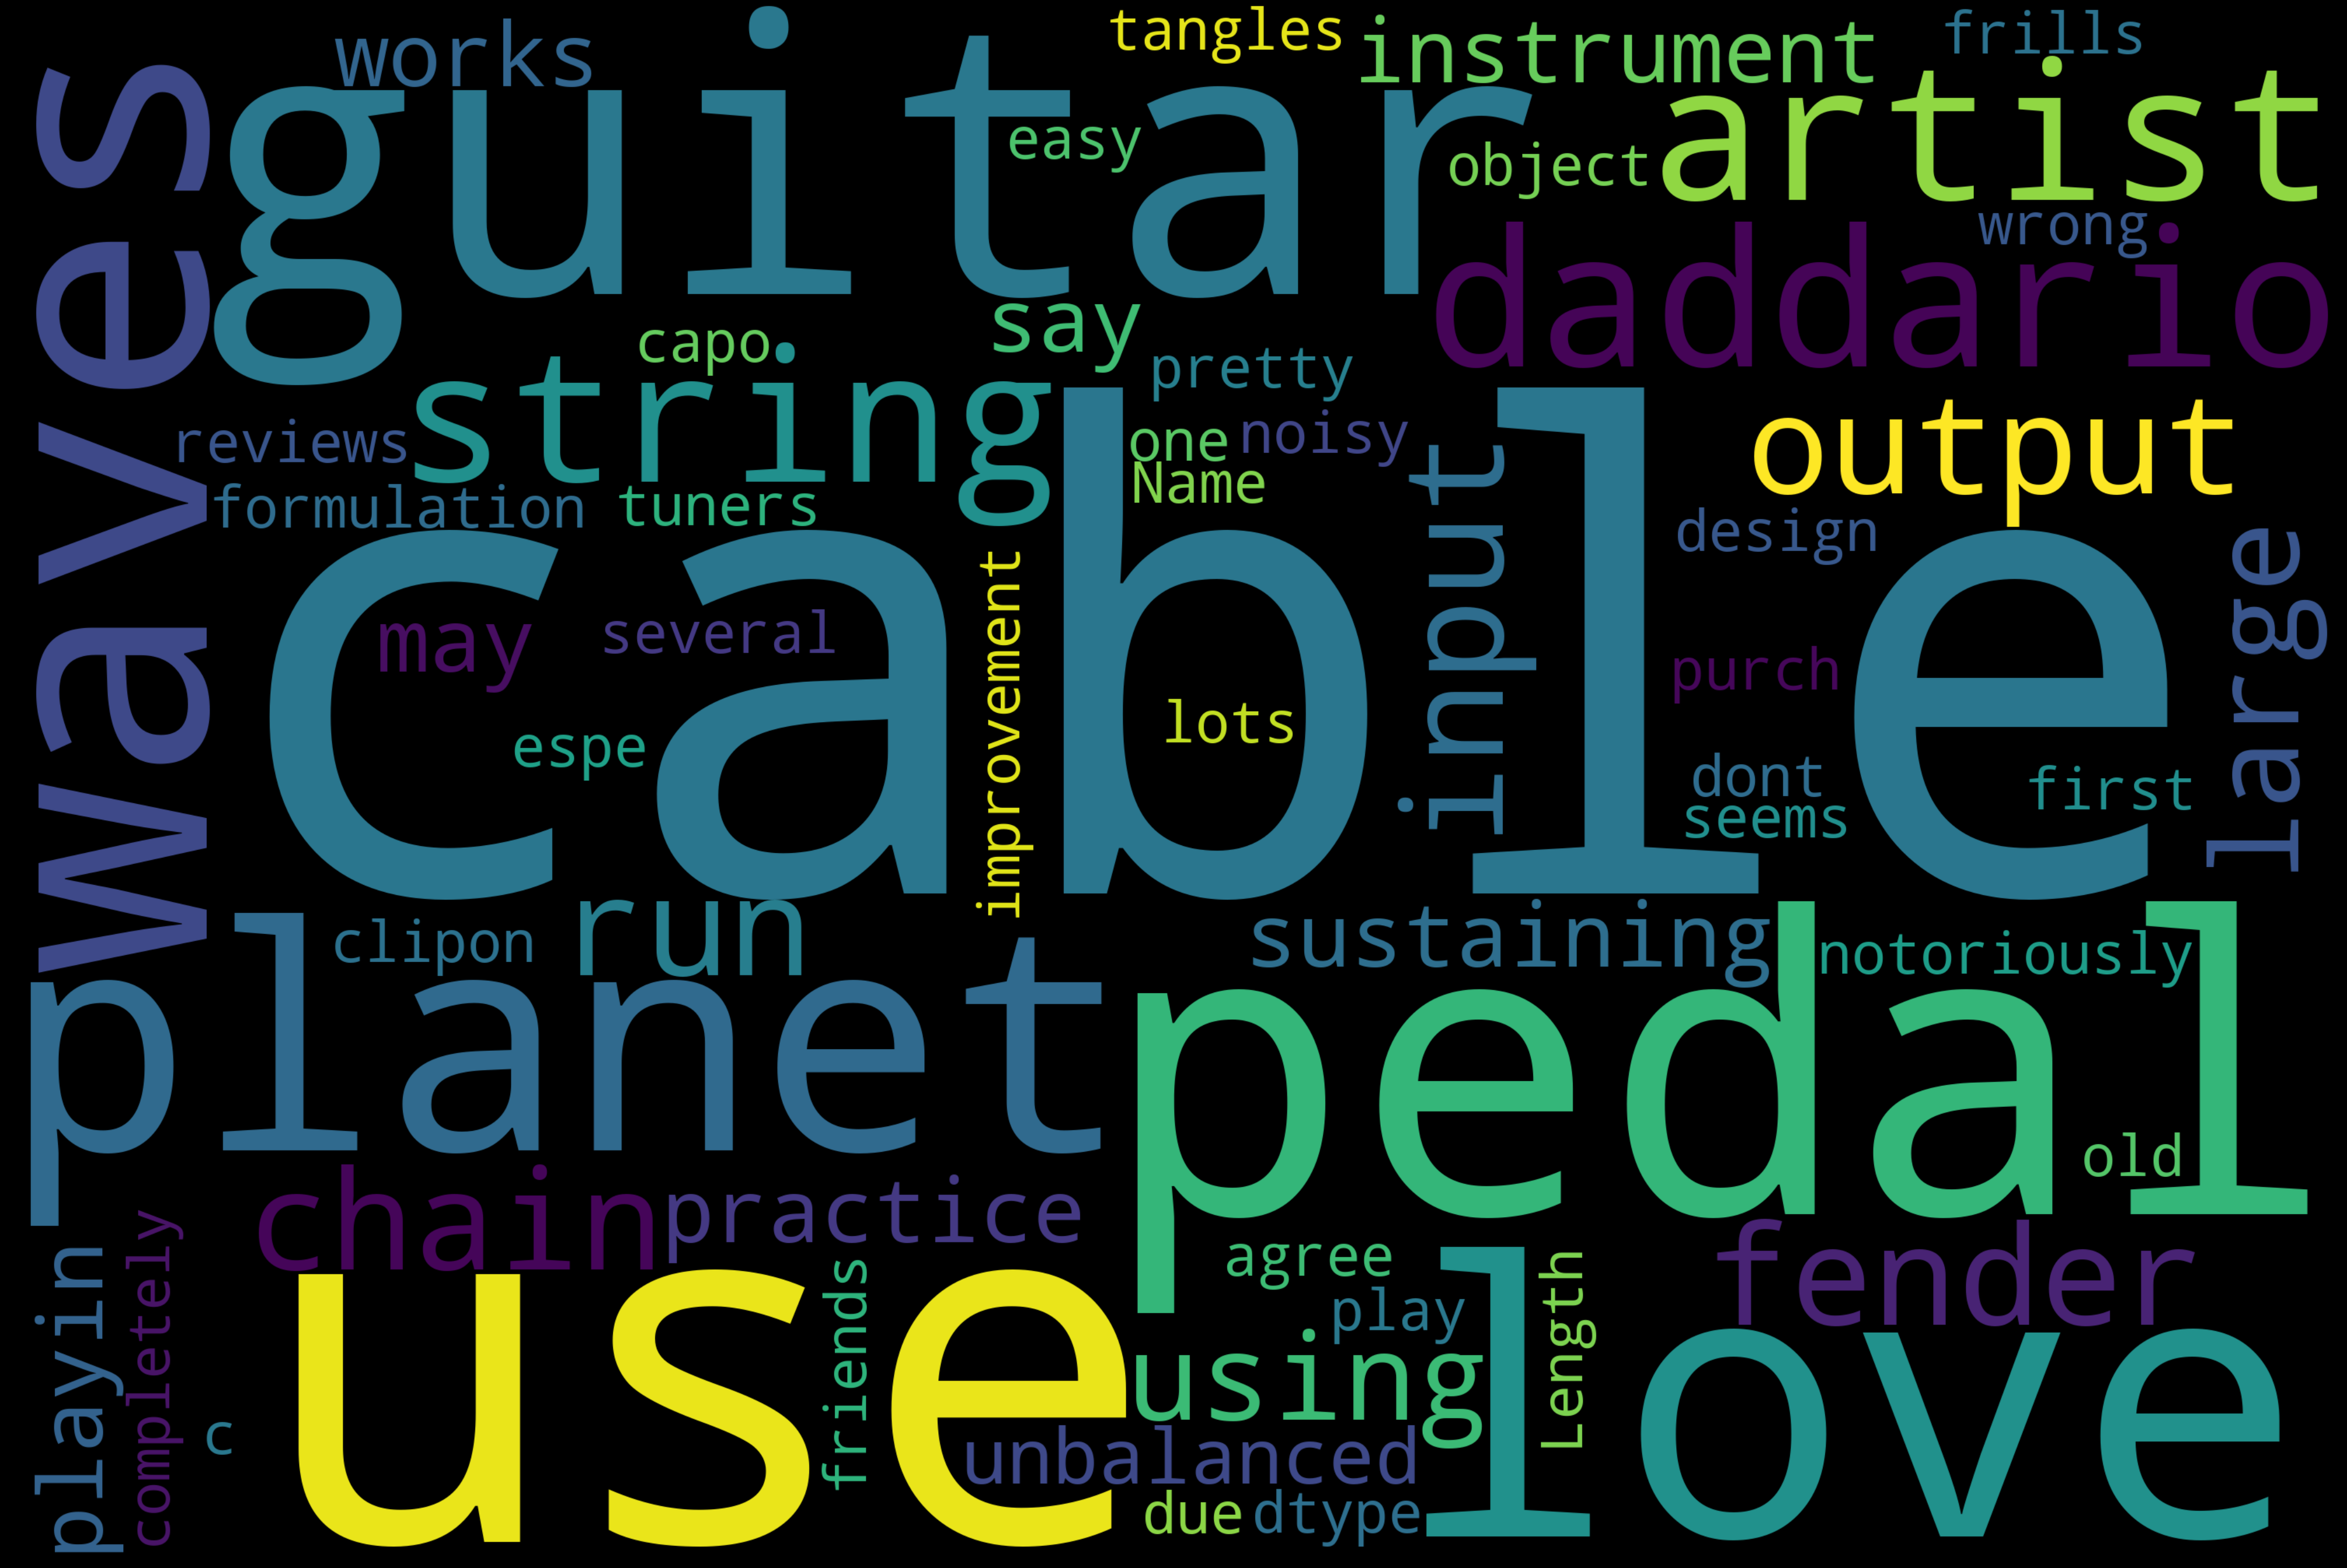

<IPython.core.display.Javascript object>

In [481]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width=3000, height=2000, background_color="black", stopwords=STOPWORDS
).generate(str(text))
fig = plt.figure(figsize=(40, 30), facecolor="k", edgecolor="k")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Most of the neutral review words are focussed on the products and how can they be improved.**

## Wordcloud-Negative reviews

**Let's look at the word cloud of negative reviews**

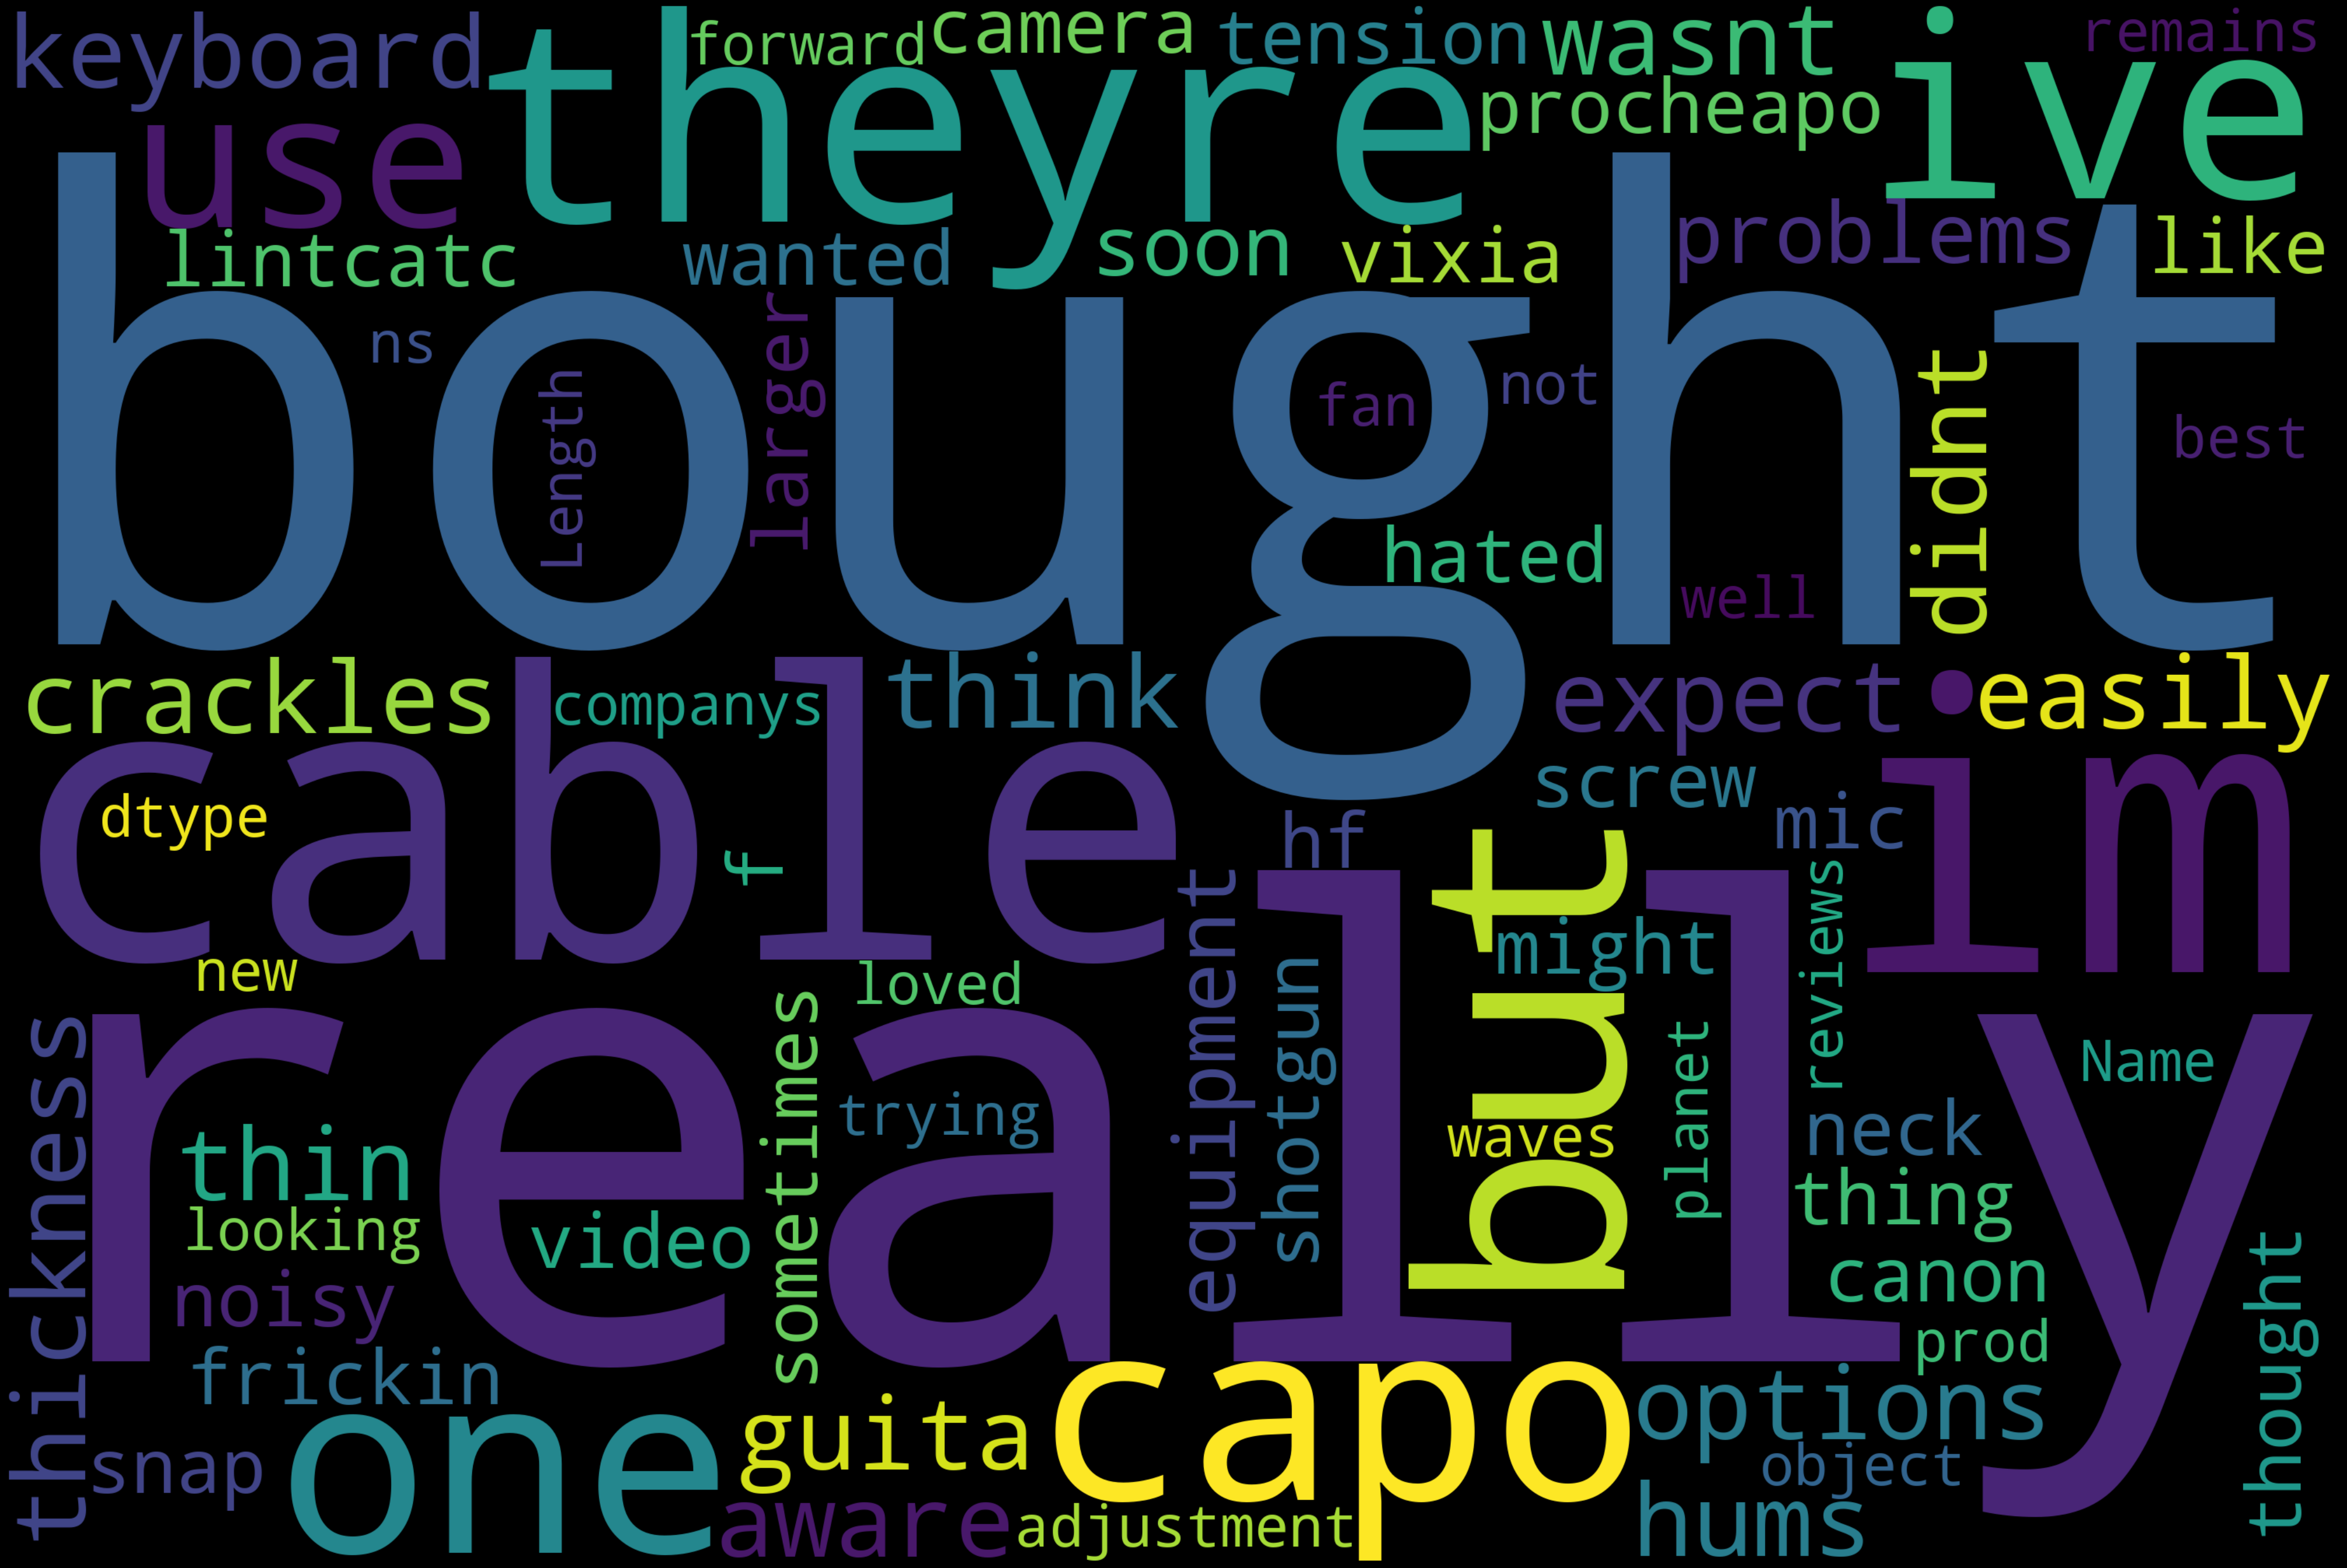

<IPython.core.display.Javascript object>

In [482]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width=3000, height=2000, background_color="black", stopwords=stop_words
).generate(str(text))
fig = plt.figure(figsize=(40, 30), facecolor="k", edgecolor="k")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**We can see negative review words such as noisy,didnt,frickin,wasnt,snap,problems,tension etc.,**

<a id="section-four"></a>
# Extracting Features from Cleaned reviews
**Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts**

## Encoding target variable-sentiment
**Let's encode our target variable with Label encoder.**

In [483]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'sentiment'.
process_reviews["sentiment"] = label_encoder.fit_transform(process_reviews["sentiment"])

process_reviews["sentiment"].unique()

array([2, 1, 0])

<IPython.core.display.Javascript object>

In [484]:
process_reviews["sentiment"].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

<IPython.core.display.Javascript object>

## Stemming the reviews


In [485]:
# Extracting 'reviews' for processing
review_features = process_reviews.copy()
review_features = review_features[["reviews"]].reset_index(drop=True)
review_features.head()

reviews
0  not much write but exactly supposed filters po...
1  product exactly quite affordablei not realized...
2  primary job device block breath would otherwis...
3  nice windscreen protects mxl mic prevents pops...
4  pop filter great looks performs like studio fi...

<IPython.core.display.Javascript object>

In [486]:
# Performing stemming on the review dataframe
ps = PorterStemmer()

# splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub("[^a-zA-Z]", " ", review_features["reviews"][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = " ".join(review)
    corpus.append(review)

<IPython.core.display.Javascript object>

In [487]:
corpus[3]

'nice windscreen protect mxl mic prevent pop thing gooseneck margin abl hold screen posit requir care posit clamp avoid sagginggood windscreen money'

<IPython.core.display.Javascript object>

## TFIDF(Term Frequency — Inverse Document Frequency)
**Here we are splitting as monogram (one word). We are also taking only the top 5000 words from the reviews. We have also tried bigrams and trigrams (they are commented out)**

In [488]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 2))
# tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(3,3))
# TF-IDF feature matrix
X = tfidf_vectorizer.fit_transform(review_features["reviews"])

<IPython.core.display.Javascript object>

In [489]:
X.shape

(10261, 5000)

<IPython.core.display.Javascript object>

**As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.**

In [490]:
# Getting the target variable(encoded)
y = process_reviews["sentiment"]
y

0        2
1        2
2        2
3        2
4        2
        ..
10256    2
10257    2
10258    2
10259    2
10260    2
Name: sentiment, Length: 10261, dtype: int32

<IPython.core.display.Javascript object>

In [491]:
# pip install nb_black

<IPython.core.display.Javascript object>

# SentimentIntensityAnalyzer

In [492]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [493]:
import nltk


<IPython.core.display.Javascript object>

In [494]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<IPython.core.display.Javascript object>

In [495]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


<IPython.core.display.Javascript object>

In [496]:
process_reviews

reviewerID        asin  overall  \
0      A2IBPI20UZIR0U  1384719342      5.0   
1      A14VAT5EAX3D9S  1384719342      5.0   
2      A195EZSQDW3E21  1384719342      5.0   
3      A2C00NNG1ZQQG2  1384719342      5.0   
4       A94QU4C90B1AX  1384719342      5.0   
...               ...         ...      ...   
10256  A14B2YH83ZXMPP  B00JBIVXGC      5.0   
10257   A1RPTVW5VEOSI  B00JBIVXGC      5.0   
10258   AWCJ12KBO5VII  B00JBIVXGC      4.0   
10259  A2Z7S8B5U4PAKJ  B00JBIVXGC      4.0   
10260  A2WA8TDCTGUADI  B00JBIVXGC      4.0   

                                                 reviews  sentiment   year  \
0      not much write but exactly supposed filters po...          2   2014   
1      product exactly quite affordablei not realized...          2   2013   
2      primary job device block breath would otherwis...          2   2013   
3      nice windscreen protects mxl mic prevents pops...          2   2014   
4      pop filter great looks performs like studio fi...          2   2014   
...                                                  ...        ...    ...   
10256                 great expected thank allfive stars          2   2014   
10257  ive thinking trying nanoweb strings but bit pu...          2   2014   
10258  tried coated strings past including elixirs ne...          2   2014   
10259  well made elixir developed taylor guitars stri...          2   2014   
10260  strings really quite good but wouldnt call per...          2   2014   

      month day  helpful_rate  polarity  review_len  word_count  
0        02  28          0.00  0.250000         162          25  
1        03  16          0.93  0.014286         356          55  
2        08  28          1.00  0.167500         315          48  
3        02  14          0.00  0.333333         169          22  
4        02  21          0.00  0.800000         136          21  
...     ...  ..           ...       ...         ...         ...  
10256    07  20          0.00  0.350000          34           5  
10257    07   2          0.00  0.183678        1870         291  
10258    07  22          0.00  0.316484         371          58  
10259    07   1          0.00  0.110938         981         153  
10260    07  16          0.00  0.384375         419          61  

[10261 rows x 12 columns]

<IPython.core.display.Javascript object>

In [497]:
df = process_reviews

<IPython.core.display.Javascript object>

In [498]:
df["scores"] = df["reviews"].apply(lambda review: sid.polarity_scores(review))
df["compound"] = df["scores"].apply(lambda score_dict: score_dict["compound"])
df["comp_score"] = df["compound"].apply(lambda c: 2 if c >= 0.3 else (0 if c <= -0.3 else 1))
df.head()


reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews  sentiment   year month  \
0  not much write but exactly supposed filters po...          2   2014    02   
1  product exactly quite affordablei not realized...          2   2013    03   
2  primary job device block breath would otherwis...          2   2013    08   
3  nice windscreen protects mxl mic prevents pops...          2   2014    02   
4  pop filter great looks performs like studio fi...          2   2014    02   

  day  helpful_rate  polarity  review_len  word_count  \
0  28          0.00  0.250000         162          25   
1  16          0.93  0.014286         356          55   
2  28          1.00  0.167500         315          48   
3  14          0.00  0.333333         169          22   
4  21          0.00  0.800000         136          21   

                                              scores  compound  comp_score  
0  {'neg': 0.103, 'neu': 0.634, 'pos': 0.263, 'co...    0.6486           2  
1  {'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'comp...    0.9359           2  
2  {'neg': 0.165, 'neu': 0.754, 'pos': 0.081, 'co...   -0.5719           0  
3  {'neg': 0.081, 'neu': 0.625, 'pos': 0.294, 'co...    0.5859           2  
4  {'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'comp...    0.7650           2

<IPython.core.display.Javascript object>

In [499]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

<IPython.core.display.Javascript object>

In [500]:
unique_comp_score = df["comp_score"].unique()
unique_comp_score

array([2, 0, 1], dtype=int64)

<IPython.core.display.Javascript object>

In [501]:
accuracy_score(df["sentiment"], df["comp_score"])

0.7795536497417406

<IPython.core.display.Javascript object>

In [502]:
print(classification_report(df["sentiment"], df["comp_score"]))

              precision    recall  f1-score   support

           0       0.23      0.34      0.27       467
           1       0.15      0.23      0.18       772
           2       0.92      0.85      0.88      9022

    accuracy                           0.78     10261
   macro avg       0.43      0.47      0.45     10261
weighted avg       0.83      0.78      0.80     10261



<IPython.core.display.Javascript object>

In [503]:
print(confusion_matrix(df["sentiment"], df["comp_score"]))

[[ 157  109  201]
 [ 101  180  491]
 [ 421  939 7662]]


<IPython.core.display.Javascript object>

<AxesSubplot:>

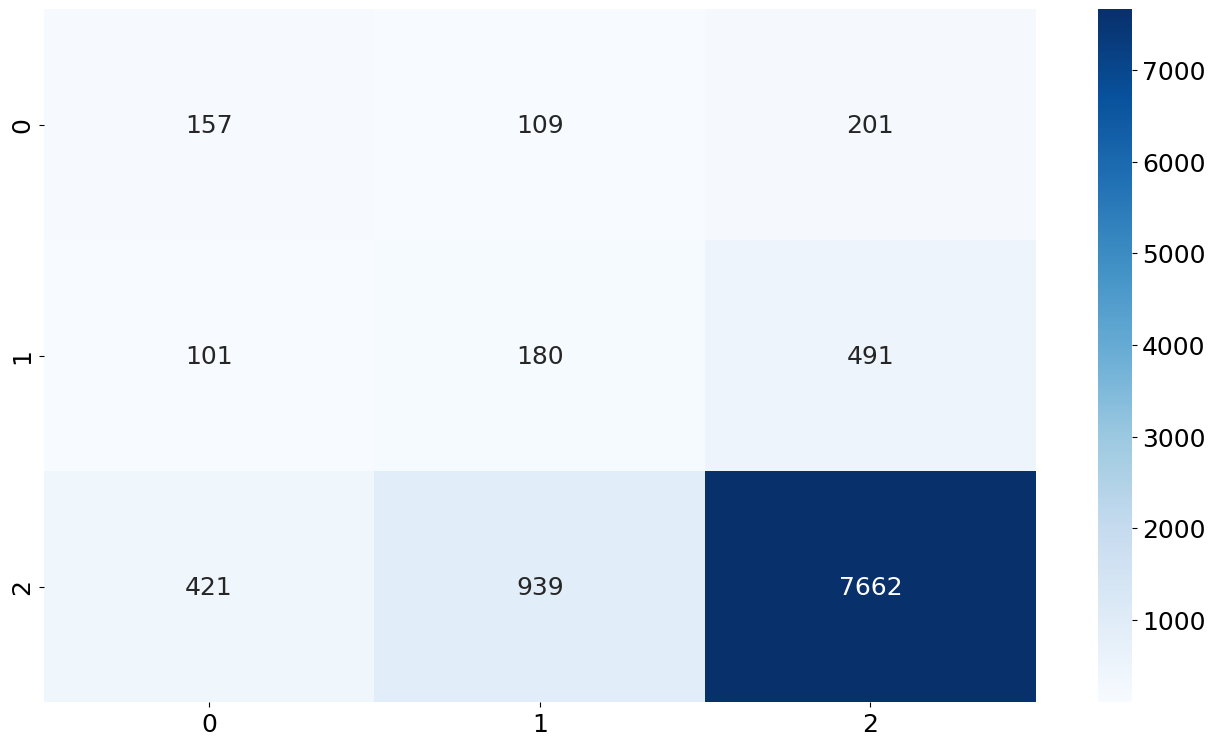

<IPython.core.display.Javascript object>

In [504]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(df["sentiment"], df["comp_score"])

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")


In [505]:
# Due to the imbalanceness of the dataset we are not able to have good analysis of the true sentiment
# We tend to categorize more positives (2) rather than neutral and negatives
# We tried with different combination on the intervals of the compound score but even if we try to better categorize the
# 1s and 0s we lose performance in the 2s (There is a tradeoff!)

<IPython.core.display.Javascript object>

In [506]:
# We decided to use other machine learing alghoritm in this case Logistic Regression to see if we are able to have a better performance

<IPython.core.display.Javascript object>

## Train-test split(75:25)
**Using train test split function we are splitting the dataset into 75:25 ratio for train and test set respectively.**

In [507]:
## Divide the dataset into Train and Test
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)
print(f"Original dataset shape : {Counter(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=0
)
print(f"Original dataset shape : {Counter(y_train)}")

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Original dataset shape : Counter({2: 6766, 1: 579, 0: 350})


<IPython.core.display.Javascript object>

# Imbalanced dataset

#We have an imbalanced dataset. We decided to try different techniques to manage this problem: 
1) Using SMOTE techinques
2) Using downsampling
3) Not adressing the problem
...
After different tries we decided to use SMOTE

In [508]:
#from sklearn.utils import resample
#import scipy.sparse

# Separate majority and minority classes
#X_train_majority = X_train[y_train==2]
#X_train_minority1 = X_train[y_train==1]
#X_train_minority0 = X_train[y_train==0]

# Downsample the majority class to 2000 samples with replacement
#X_train_majority_downsampled, y_train_majority_downsampled = resample(X_train_majority, y_train[y_train==2],
#                                                                     replace=True,
#                                                                     n_samples=600,
#                                                                     random_state=0)
#
# Combine minority classes with downsampled majority class
#X_train_downsampled = scipy.sparse.vstack((X_train_majority_downsampled, X_train_minority1, X_train_minority0))
#y_train_downsampled = np.concatenate((y_train_majority_downsampled, y_train[y_train!=2]))
#
#
#X_train= X_train_downsampled
#y_train= y_train_downsampled 
# Train the model using the downsampled data
#model.fit(X_train, y_train)


<IPython.core.display.Javascript object>

In [509]:
print(f"Original dataset shape : {Counter(y_train)}")

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset shape {Counter(y_train)}")

Original dataset shape : Counter({2: 6766, 1: 579, 0: 350})
Resampled dataset shape Counter({2: 6766, 1: 6766, 0: 6766})


<IPython.core.display.Javascript object>

## Model selection

**First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process**

In [510]:
# creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv = DecisionTreeClassifier()
knn_cv = KNeighborsClassifier()
svc_cv = SVC()
nb_cv = BernoulliNB()
cv_dict = {
    0: "Logistic Regression",
    1: "Decision Tree",
    2: "KNN",
    3: "SVC",
    4: "Naive Bayes",
}
cv_models = [logreg_cv, dt_cv, knn_cv, svc_cv, nb_cv]


for i, model in enumerate(cv_models):
    print(
        "{} Test f1_macro: {}".format(
            cv_dict[i], cross_val_score(model, X, y, cv=10, scoring="f1_macro").mean()
        )
    )

Logistic Regression Test f1_macro: 0.3972797858619625
Decision Tree Test f1_macro: 0.4115192178587
KNN Test f1_macro: 0.3528489215278282
SVC Test f1_macro: 0.3240356607550305
Naive Bayes Test f1_macro: 0.40446620206278566


<IPython.core.display.Javascript object>

# Logistic Regression

In [511]:
#DEFINE YOUR CLASSIFIER and THE PARAMETERS GRID
from sklearn.linear_model import LogisticRegression
import numpy as np

#from sklearn.linear_model import LogisticRegression
import numpy as np

classifier = LogisticRegression()
parameters = {
    "C": [0.0005, 0.001],
    "penalty": ['l2', 'l1'],
    "max_iter": [25, 10, 5],
    "multi_class": ['auto', 'ovr']
}

#When we were trying with the imbalanced dataset we use a dictionary to try to push the classification of the zero and ones
#"class_weight": [{0:8, 1:6, 2:1}],  as a aparametre in the LogReg


<IPython.core.display.Javascript object>

In [512]:
# DEFINE YOUR GRIDSEARCH
"""

GS perfoms an exhaustive search over specified parameter values for an estimator.
GS uses a Stratified K-Folds cross-validator
(The folds are made by preserving the percentage of samples for each class.)
If refit=True the model is retrained on the whole training set with the best found params
"""
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    classifier, parameters, cv=5, scoring="f1_macro", verbose=50, n_jobs=-1, refit=True
)

# We decided to use the f1_macro as scoring because assuming the test set imbalanced the accuracy wasn't giving us enough
# information on the correct classification of zeros and ones.

<IPython.core.display.Javascript object>

In [513]:
# TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


<IPython.core.display.Javascript object>

In [514]:
# summarize the results of your GRIDSEARCH
print("***GRIDSEARCH RESULTS***")

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_["mean_test_score"]
stds = gs.cv_results_["std_test_score"]
params = gs.cv_results_["params"]

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.757253 using {'C': 0.001, 'max_iter': 25, 'multi_class': 'auto', 'penalty': 'l2'}
0.754165 (0.013304) with: {'C': 0.0005, 'max_iter': 25, 'multi_class': 'auto', 'penalty': 'l2'}
nan (nan) with: {'C': 0.0005, 'max_iter': 25, 'multi_class': 'auto', 'penalty': 'l1'}
0.753496 (0.013263) with: {'C': 0.0005, 'max_iter': 25, 'multi_class': 'ovr', 'penalty': 'l2'}
nan (nan) with: {'C': 0.0005, 'max_iter': 25, 'multi_class': 'ovr', 'penalty': 'l1'}
0.754165 (0.013304) with: {'C': 0.0005, 'max_iter': 10, 'multi_class': 'auto', 'penalty': 'l2'}
nan (nan) with: {'C': 0.0005, 'max_iter': 10, 'multi_class': 'auto', 'penalty': 'l1'}
0.753496 (0.013263) with: {'C': 0.0005, 'max_iter': 10, 'multi_class': 'ovr', 'penalty': 'l2'}
nan (nan) with: {'C': 0.0005, 'max_iter': 10, 'multi_class': 'ovr', 'penalty': 'l1'}
0.754165 (0.013304) with: {'C': 0.0005, 'max_iter': 5, 'multi_class': 'auto', 'penalty': 'l2'}
nan (nan) with: {'C': 0.0005, 'max_iter': 5, 'multi_class': 

<IPython.core.display.Javascript object>

In [515]:
# TEST ON YOUR TEST SET
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

<IPython.core.display.Javascript object>

In [516]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print("RESULTS ON TEST SET")
result1 = classification_report(y_test, y_pred)

print("Classification Report:")
print(result1)
result2 = accuracy_score(y_test, y_pred)
print("Accuracy:", result2)

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print("RESULTS ON TRAIN SET")
result1 = classification_report(y_train, y_pred_train)
print("Classification Report:")
print(result1)
result2 = accuracy_score(y_train, y_pred_train)
print("Accuracy:", result2)

RESULTS ON TEST SET
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.56      0.26       117
           1       0.20      0.36      0.26       193
           2       0.95      0.77      0.85      2256

    accuracy                           0.73      2566
   macro avg       0.44      0.56      0.46      2566
weighted avg       0.85      0.73      0.78      2566

Accuracy: 0.7272018706157444
RESULTS ON TRAIN SET
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      6766
           1       0.78      0.68      0.72      6766
           2       0.74      0.78      0.76      6766

    accuracy                           0.77     20298
   macro avg       0.77      0.77      0.77     20298
weighted avg       0.77      0.77      0.77     20298

Accuracy: 0.7687949551679969


<IPython.core.display.Javascript object>

<AxesSubplot:>

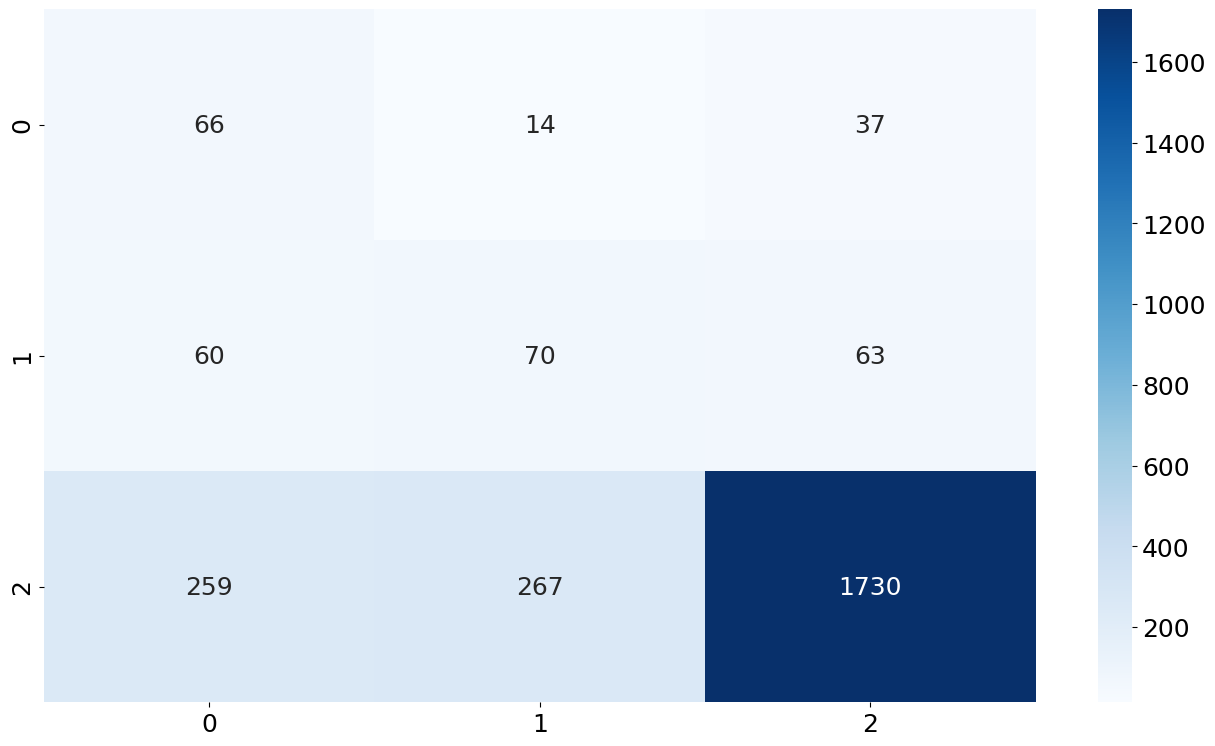

<IPython.core.display.Javascript object>

In [517]:
# CONFUSION MATRIX on test
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")

<AxesSubplot:>

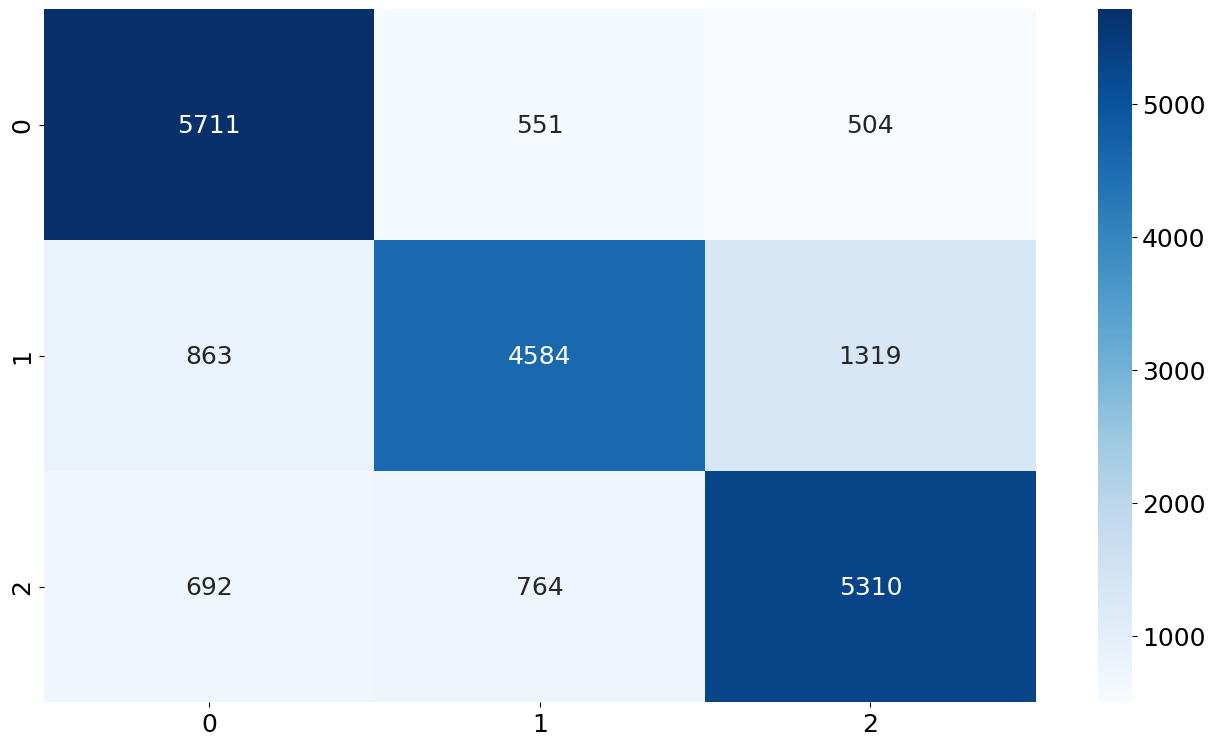

<IPython.core.display.Javascript object>

In [518]:
# CONFUSION MATRIX on train
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt="d", cmap="Blues")

In [519]:
# We noticed that we have a little overfitting (4% difference in accuracy between train and test)

<IPython.core.display.Javascript object>

# Decision Tree Classifier

In [520]:
# Define classifier and parameters gridsearch
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
parameters = {
    "criterion": ["entropy", "gini"],
    "max_depth": [
        6,
        7,
        8,
        9,
    ],
    # "class_weight": [{0:14, 1:10, 2:1}],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [2, 3, 4, 5],
}

<IPython.core.display.Javascript object>

In [521]:
# Define gridsearch

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    classifier, parameters, cv=3, scoring="f1_macro", verbose=10, n_jobs=-1
)
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


<IPython.core.display.Javascript object>

In [522]:
# summarize the results of your GRIDSEARCH
print("***GRIDSEARCH RESULTS***")

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_["mean_test_score"]
stds = gs.cv_results_["std_test_score"]
params = gs.cv_results_["params"]

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.714298 using {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.615003 (0.011740) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.615333 (0.011393) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.615216 (0.011704) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.615109 (0.011719) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.615549 (0.011384) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.615122 (0.011529) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.615276 (0.011589) with: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.615317 (0.011538) with: {'criterion': 'entropy', 'max_depth': 6

<IPython.core.display.Javascript object>

In [523]:
# TEST ON YOUR TEST SET
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

<IPython.core.display.Javascript object>

In [524]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print("RESULTS ON TEST SET")
result1 = classification_report(y_test, y_pred)

print("Classification Report:")
print(result1)
result2 = accuracy_score(y_test, y_pred)
print("Accuracy:", result2)

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print("RESULTS ON TRAIN SET")
result1 = classification_report(y_train, y_pred_train)
print("Classification Report:")
print(result1)
result2 = accuracy_score(y_train, y_pred_train)
print("Accuracy:", result2)

RESULTS ON TEST SET
Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.35      0.13       117
           1       0.17      0.23      0.19       193
           2       0.92      0.72      0.81      2256

    accuracy                           0.67      2566
   macro avg       0.39      0.44      0.38      2566
weighted avg       0.82      0.67      0.73      2566

Accuracy: 0.6703039750584567
RESULTS ON TRAIN SET
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      6766
           1       0.81      0.59      0.68      6766
           2       0.78      0.75      0.77      6766

    accuracy                           0.74     20298
   macro avg       0.76      0.74      0.74     20298
weighted avg       0.76      0.74      0.74     20298

Accuracy: 0.7440141885900089


<IPython.core.display.Javascript object>

<AxesSubplot:>

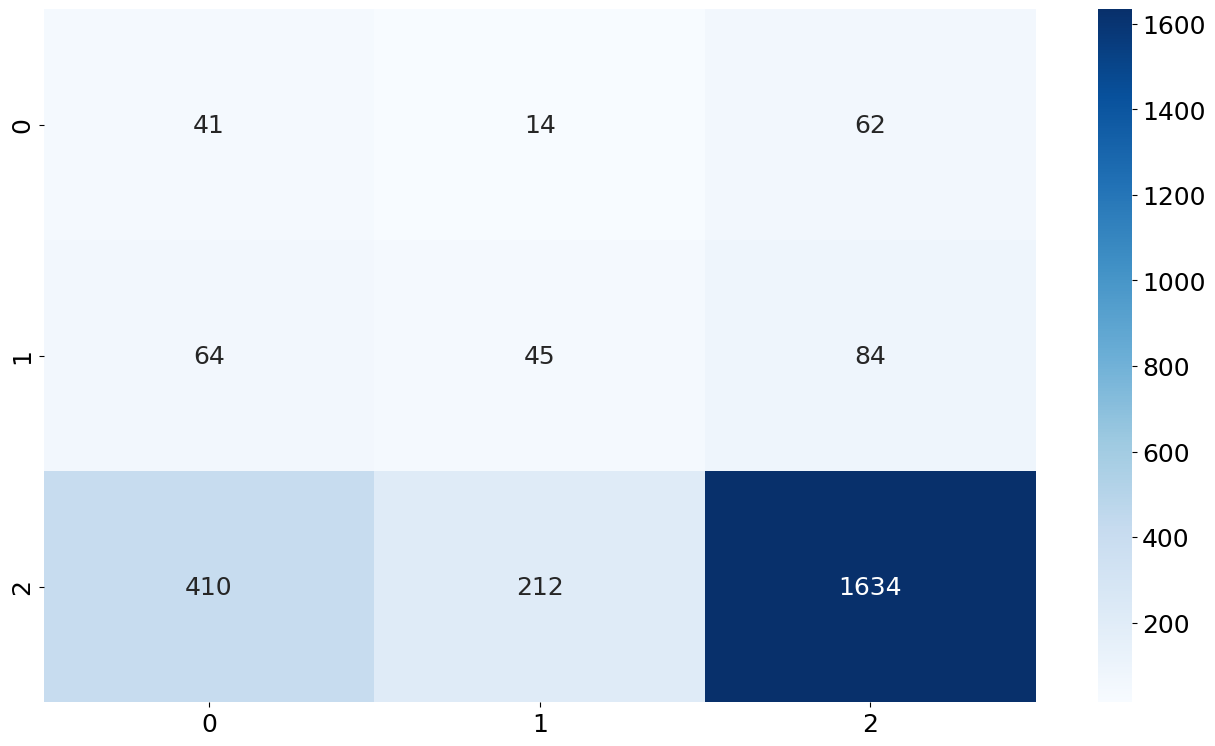

<IPython.core.display.Javascript object>

In [525]:
# CONFUSION MATRIX on test
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")

<AxesSubplot:>

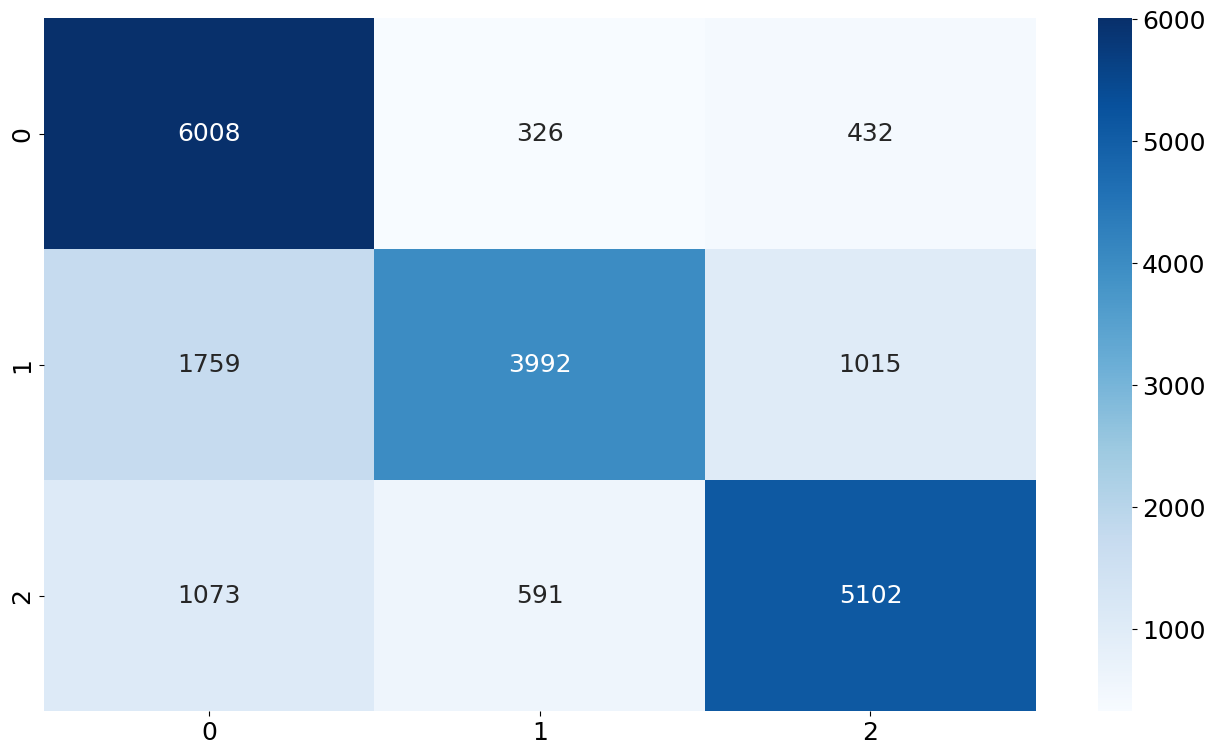

<IPython.core.display.Javascript object>

In [526]:
# CONFUSION MATRIX on train
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt="d", cmap="Blues")

# Conclusion

Logistic Regression is a better fit for our dataset rather than Decision Tree Classifier

# Topic Modeling with LDA

In [527]:
data = df["reviews"]
data

0        not much write but exactly supposed filters po...
1        product exactly quite affordablei not realized...
2        primary job device block breath would otherwis...
3        nice windscreen protects mxl mic prevents pops...
4        pop filter great looks performs like studio fi...
                               ...                        
10256                   great expected thank allfive stars
10257    ive thinking trying nanoweb strings but bit pu...
10258    tried coated strings past including elixirs ne...
10259    well made elixir developed taylor guitars stri...
10260    strings really quite good but wouldnt call per...
Name: reviews, Length: 10261, dtype: object

<IPython.core.display.Javascript object>

In [528]:
from sklearn.feature_extraction.text import CountVectorizer

<IPython.core.display.Javascript object>

In [529]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")

<IPython.core.display.Javascript object>

In [530]:
dtm = cv.fit_transform(data)

<IPython.core.display.Javascript object>

In [531]:
dtm

<10261x12229 sparse matrix of type '<class 'numpy.int64'>'
	with 329632 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [532]:
from sklearn.decomposition import LatentDirichletAllocation

<IPython.core.display.Javascript object>

In [533]:
LDA = LatentDirichletAllocation(n_components=7, random_state=42)

<IPython.core.display.Javascript object>

In [534]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=7, random_state=42)

<IPython.core.display.Javascript object>

In [535]:
len(cv.get_feature_names())

12229

<IPython.core.display.Javascript object>

In [536]:
import random

<IPython.core.display.Javascript object>

In [537]:
for i in range(10):
    random_word_id = random.randint(0, 12228)
    print(cv.get_feature_names()[random_word_id])

cordless
quiets
parties
mouth
shimmer
superbly
size
flatpick
victim
preset


<IPython.core.display.Javascript object>

In [538]:
for i in range(10):
    random_word_id = random.randint(0, 12228)
    print(cv.get_feature_names()[random_word_id])

informed
mounting
approximate
lease
flexible
tortex
tome
distance
permanent
teacher


<IPython.core.display.Javascript object>

In [539]:
len(LDA.components_)

7

<IPython.core.display.Javascript object>

In [540]:
LDA.components_

array([[ 0.14293522,  0.14307146,  0.1430524 , ...,  0.14296535,
         0.14285716,  0.14316765],
       [ 2.09984244,  0.14289122,  0.14291821, ..., 55.99273326,
         0.14547495,  0.14295269],
       [ 0.1429164 ,  0.14298579,  1.15503167, ...,  0.14301916,
         0.14285716, 19.14007622],
       ...,
       [ 0.77647675,  0.14316838,  0.14310949, ...,  0.14312491,
         0.20236145,  0.14292174],
       [ 7.38046948,  9.02272764, 12.84180258, ...,  3.03666185,
         5.07977845,  0.14309414],
       [ 0.14358935,  2.73421405,  8.85179114, ...,  4.522331  ,
         0.14301677,  0.1445243 ]])

<IPython.core.display.Javascript object>

In [541]:
single_topic = LDA.components_[0]

<IPython.core.display.Javascript object>

In [542]:
single_topic.argsort()

array([1815, 6911, 8446, ..., 4429, 4532, 9966], dtype=int64)

<IPython.core.display.Javascript object>

In [543]:
single_topic[4532]

934.8041550256054

<IPython.core.display.Javascript object>

In [544]:
single_topic[9966]

1030.783435772364

<IPython.core.display.Javascript object>

In [545]:
single_topic.argsort()[-10:]

array([ 5893,  5952, 12056,   745,  7993,  4342,  1514,  4429,  4532,
        9966], dtype=int64)

<IPython.core.display.Javascript object>

In [546]:
top_word_indices = single_topic.argsort()[-10:]

<IPython.core.display.Javascript object>

In [547]:
for index in top_word_indices:
    print(cv.get_feature_names()[index])

like
little
works
bag
price
good
case
great
guitar
stand


<IPython.core.display.Javascript object>

In [548]:
for index, topic in enumerate(LDA.components_):
    print(f"THE TOP 15 WORDS FOR TOPIC #{index}")
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print("\n")

THE TOP 15 WORDS FOR TOPIC #0
['stands', 'really', 'bought', 'product', 'nice', 'like', 'little', 'works', 'bag', 'price', 'good', 'case', 'great', 'guitar', 'stand']


THE TOP 15 WORDS FOR TOPIC #1
['recording', 'using', 'product', 'nice', 'guitars', 'work', 'quality', 'easy', 'works', 'like', 'good', 'great', 'use', 'guitar', 'strap']


THE TOP 15 WORDS FOR TOPIC #2
['used', 'play', 'playing', 'tone', 'feel', 'use', 'ive', 'good', 'guitar', 'pick', 'like', 'great', 'picks', 'sound', 'strings']


THE TOP 15 WORDS FOR TOPIC #3
['studio', 'mics', 'works', 'like', 'sound', 'stand', 'use', 'microphone', 'price', 'great', 'quality', 'cables', 'good', 'cable', 'mic']


THE TOP 15 WORDS FOR TOPIC #4
['tuners', 'dont', 'easy', 'little', 'guitars', 'capo', 'tune', 'use', 'good', 'string', 'like', 'great', 'strings', 'tuner', 'guitar']


THE TOP 15 WORDS FOR TOPIC #5
['works', 'supply', 'need', 'effects', 'dont', 'unit', 'great', 'battery', 'switch', 'board', 'use', 'pedals', 'like', 'power', '

<IPython.core.display.Javascript object>

In [549]:
# TOPICs NAMES

# Topic 0: "Portable and Affordable Guitar Stands and Cases"
# Topic 1: "Easy-to-Use Guitar Recording Equipment and Straps"
# Topic 2: "Choosing the Right Guitar Picks and Strings for Tone and Feel"
# Topic 3: "Affordable Studio Microphones, Cables, and Stands"
# Topic 4: "Efficient and Accurate Guitar Tuners and Capos"
# Topic 5: "Versatile Effects Pedals and Power Supplies for Guitarists"
# Topic 6: "Tube and Solid-State Guitar Pedals for Distortion and Clean Sounds"

<IPython.core.display.Javascript object>